# Sustainable AI: Energy-Efficient Prompt Engineering

This notebook supports the development of a machine learning model that predicts the energy usage of language model inference tasks based on prompt characteristics. The goal is to help optimize prompt inputs and improve transparency in AI system energy consumption.

**Dataset**: [Hugging Face - LLM Inference Energy Consumption](https://huggingface.co/datasets/ejhusom/llm-inference-energy-consumption)


## Importing the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

## Loading the dataset

In [4]:
df = pd.read_csv("../data/alpaca_llama3_70b_server.csv")

print("Dataset loaded successfully.")

Dataset loaded successfully.


## EDA 

###  Basic information about the dataset

In [5]:
print("First few rows of the dataset: ")
print(df.head(10))
print("---------------------------*---------------------------*---------------------------*---------------------------*---------------------------*---------------------------*")
print("Dataset information: ")
df.info()
print("---------------------------*---------------------------*---------------------------*---------------------------*---------------------------*---------------------------*")
print("Dataset description: ")
df.describe()
df.info()
print("---------------------------*---------------------------*---------------------------*---------------------------*---------------------------*---------------------------*")
print("Checking for missing values in the dataset: ")
print(df.isnull().sum())

First few rows of the dataset: 
   Unnamed: 0.1  Unnamed: 0  index  model_name  \
0             0           0      0  llama3:70b   
1             1           1      0  llama3:70b   
2             2           2      0  llama3:70b   
3             3           3      0  llama3:70b   
4             4           4      0  llama3:70b   
5             5           5      0  llama3:70b   
6             6           6      0  llama3:70b   
7             7           7      0  llama3:70b   
8             8           8      0  llama3:70b   
9             9           9      0  llama3:70b   

                            created_at  total_duration  load_duration  \
0  2024-05-23 09:15:00.187929369+00:00     94879729212     8831648220   
1  2024-05-23 09:15:18.245447446+00:00     14599356392         317320   
2  2024-05-23 09:18:31.047288630+00:00    189692748218         571421   
3  2024-05-23 09:21:57.558292165+00:00    202650658347         362015   
4  2024-05-23 09:23:29.453819226+00:00     880475737

### Distribution of Energy Consumption  (kWh)

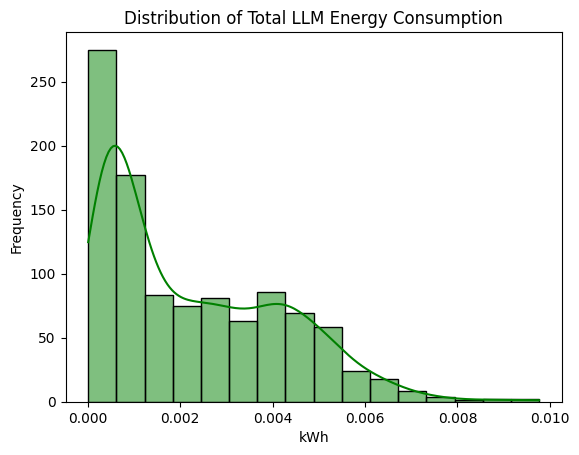

In [6]:
sns.histplot(df['energy_consumption_llm_total'], kde=True, color='green')
plt.title("Distribution of Total LLM Energy Consumption")
plt.xlabel("kWh")
plt.ylabel("Frequency")
plt.show()

This histogram shows that most LLM prompts consume less than 0.002 kWh, with a few outliers using significantly more energy. The distribution is right-skewed, indicating low average use but high peaks, which are critical for optimization

### Average Energy Consumption per LLM Model

C:\Users\User\AppData\Local\Temp\ipykernel_21028\3890987910.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_energy.values, y=model_energy.index, palette="mako")


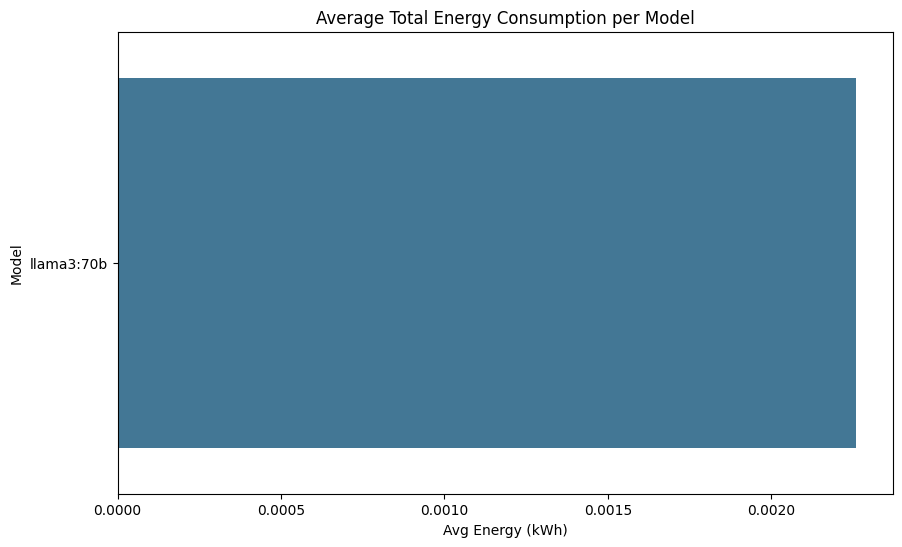

In [7]:
model_energy = df.groupby("model_name")["energy_consumption_llm_total"].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=model_energy.values, y=model_energy.index, palette="mako")
plt.title("Average Total Energy Consumption per Model")
plt.xlabel("Avg Energy (kWh)")
plt.ylabel("Model")
plt.show()

This bar plot shows the average total energy consumed by each LLM model.

### Response Token Length vs Energy Consumption

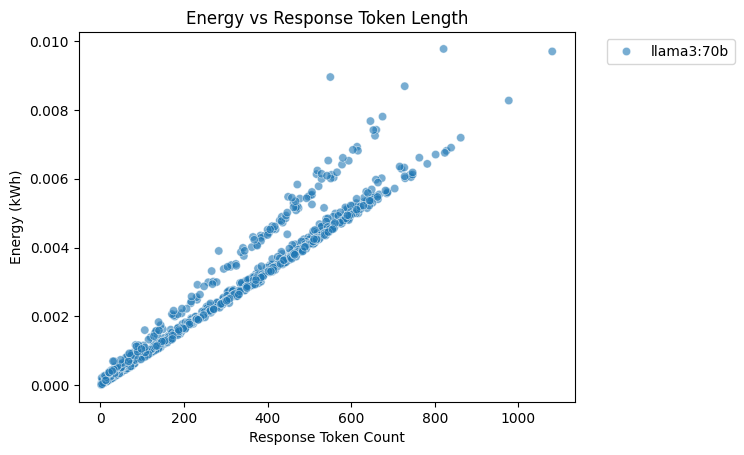

In [8]:
sns.scatterplot(
    data=df, 
    x="response_token_length", 
    y="energy_consumption_llm_total", 
    hue="model_name", 
    alpha=0.6
)
plt.title("Energy vs Response Token Length")
plt.xlabel("Response Token Count")
plt.ylabel("Energy (kWh)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


This scatter plot shows how response token length impacts total energy consumption, grouped by model.
Larger responses generally lead to higher energy use, with variation across different models.

### Text Complexity vs Energy Use

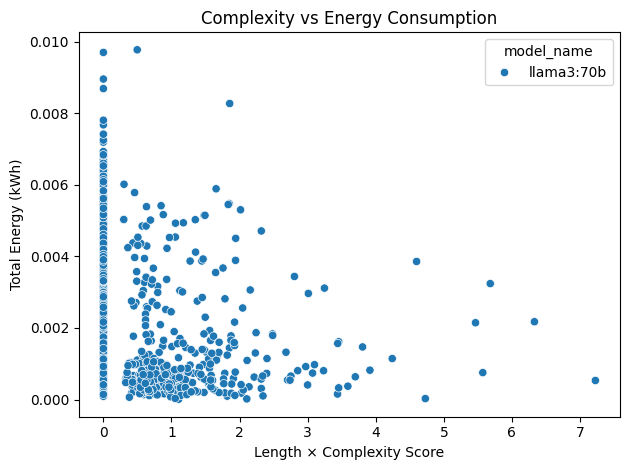

In [9]:
sns.scatterplot(data=df, x="length_x_complexity", y="energy_consumption_llm_total", hue="model_name")
plt.title("Complexity vs Energy Consumption")
plt.xlabel("Length × Complexity Score")
plt.ylabel("Total Energy (kWh)")
plt.tight_layout()
plt.show()

This scatter plot visualizes how the combined length and complexity of prompts relates to total energy usage.
Higher complexity often leads to greater energy consumption, with distinct patterns across different models.

### Boxplot of Readability Scores by Prompt Type

C:\Users\User\AppData\Local\Temp\ipykernel_21028\1157854809.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="type", y="flesch_reading_ease", palette="coolwarm")


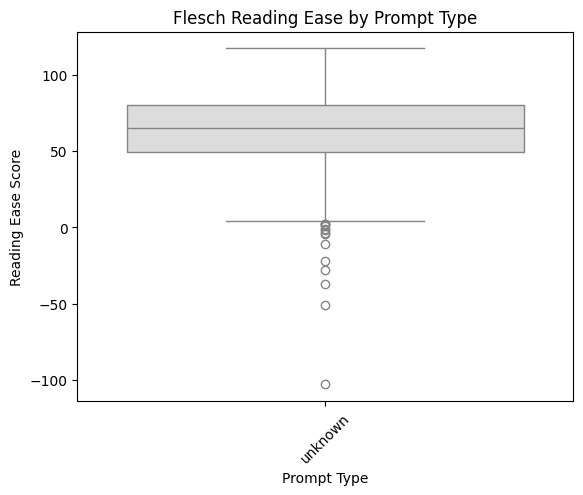

In [10]:
sns.boxplot(data=df, x="type", y="flesch_reading_ease", palette="coolwarm")
plt.title("Flesch Reading Ease by Prompt Type")
plt.xlabel("Prompt Type")
plt.ylabel("Reading Ease Score")
plt.xticks(rotation=45)
plt.show()

This boxplot compares text readability scores across different prompt types.
Some types tend to have more complex language, reflected by lower reading ease scores.

### Word Count vs Energy with Sentiment Hue

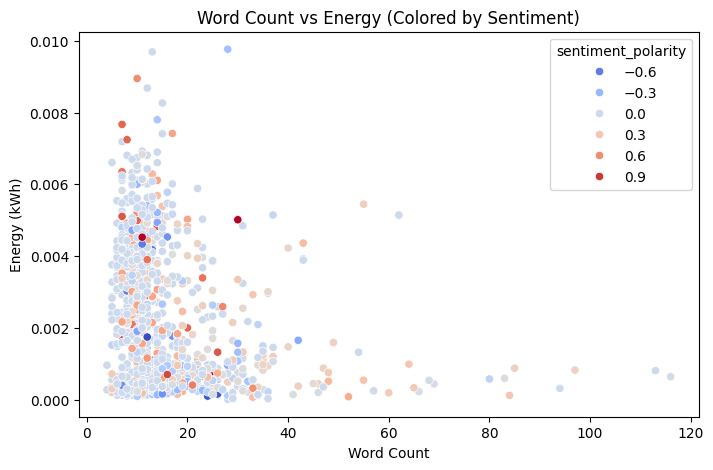

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="word_count", y="energy_consumption_llm_total", hue="sentiment_polarity", palette="coolwarm")
plt.title("Word Count vs Energy (Colored by Sentiment)")
plt.xlabel("Word Count")
plt.ylabel("Energy (kWh)")
plt.show()

This scatter plot shows how word count correlates with energy consumption, with color representing sentiment polarity.
Longer texts generally use more energy, and sentiment appears to have minimal direct influence.

### Violin Plot: Sentence Embedding Variance by Model

C:\Users\User\AppData\Local\Temp\ipykernel_21028\2938930140.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="model_name", y="sentence_embedding_variance", inner="quartile", palette="Set2")


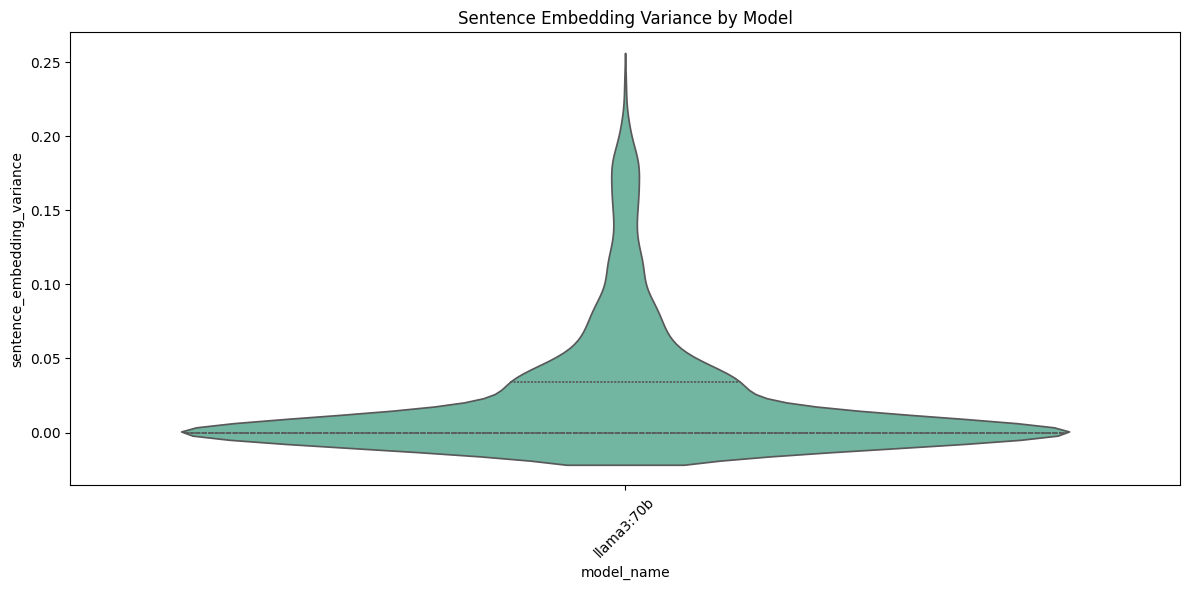

In [12]:
plt.figure(figsize=(12,6))
sns.violinplot(data=df, x="model_name", y="sentence_embedding_variance", inner="quartile", palette="Set2")
plt.xticks(rotation=45)
plt.title("Sentence Embedding Variance by Model")
plt.tight_layout()
plt.show()

This violin plot shows the distribution of sentence embedding variance for the model llama3:70b.
Most outputs have very low variance, suggesting high consistency in semantic structure across generated responses.

###  Full Correlation HeatMap (of numeric features)

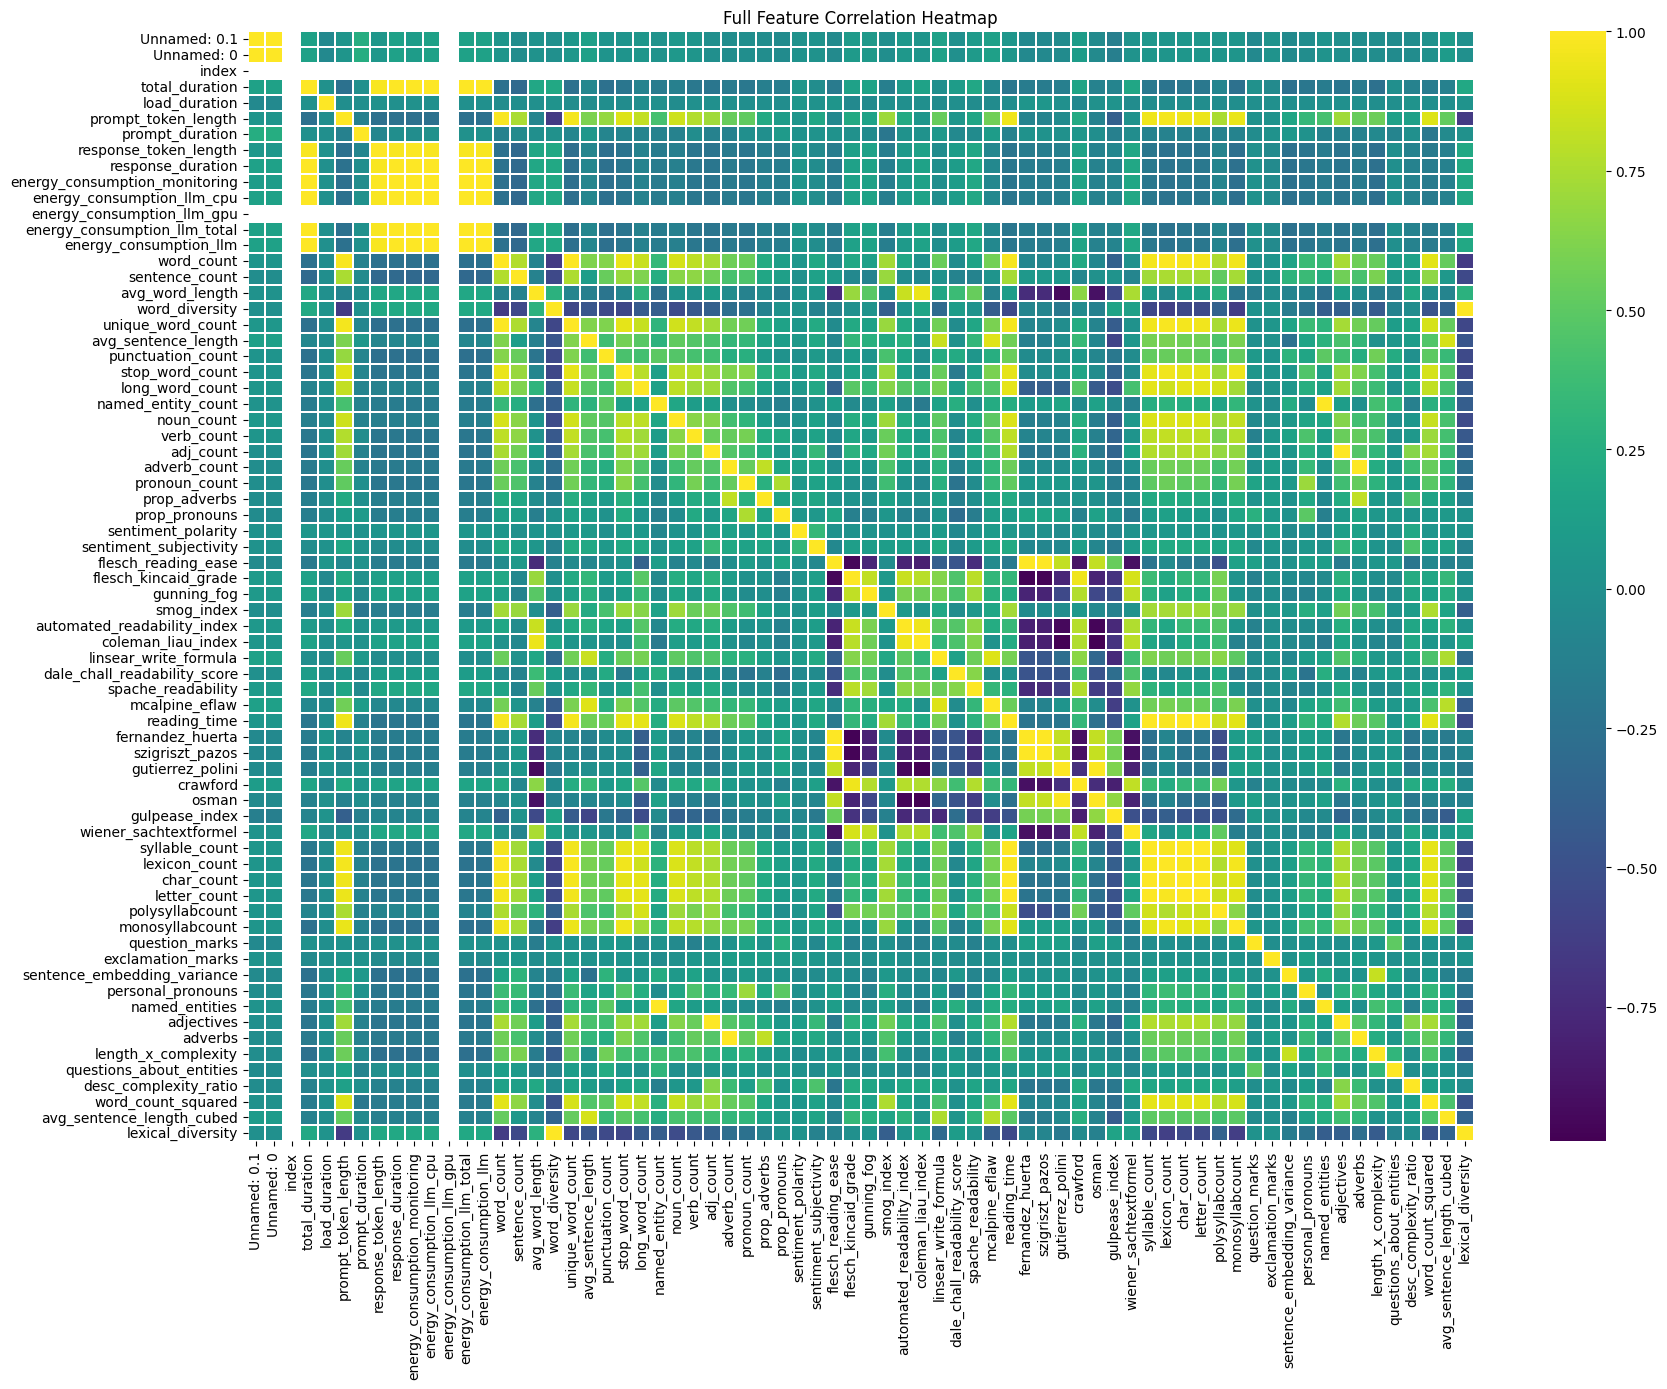

In [13]:
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr(numeric_only=True)['energy_consumption_llm_total'].abs().sort_values(ascending=False)[1:21]

plt.figure(figsize=(18,14))
sns.heatmap(numeric_df.corr(), cmap="viridis", annot=False, linewidths=0.3)
plt.title("Full Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

This heatmap visualizes pairwise correlations across all numeric features.
Clusters reveal strong relationships between groups of linguistic, readability, and energy-related metrics — useful for feature selection and redundancy reduction.

### Line Plot: Energy over Time

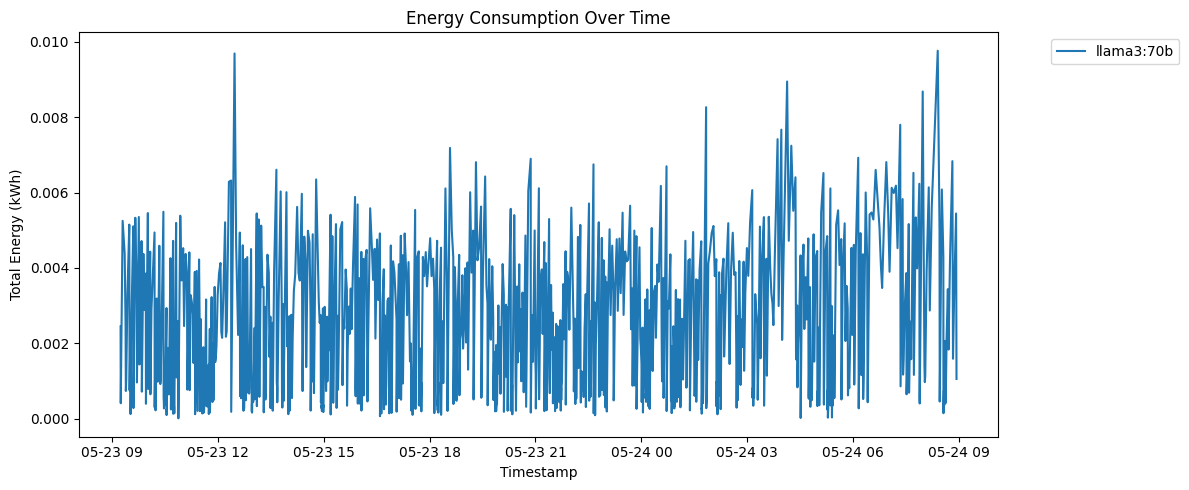

In [14]:
df['created_at'] = pd.to_datetime(df['created_at'])
df_sorted = df.sort_values('created_at')

plt.figure(figsize=(12,5))
sns.lineplot(data=df_sorted, x="created_at", y="energy_consumption_llm_total", hue="model_name")
plt.title("Energy Consumption Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Total Energy (kWh)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This line chart shows how energy usage fluctuates over time for the llama3:70b model.
Despite short-term spikes, energy use remains within a narrow band, highlighting consistent demand during inference.

## Cleaning and preprocessing the data

### Dropping Unecessary Columns

In [15]:
# We remove irrelevant metadata such as index columns and timestamps
df.drop(columns=[
    "Unnamed: 0", "Unnamed: 0.1", "index",
    "created_at", "start_time", "end_time", "clock_duration"
], inplace=True, errors="ignore")
print("Unnecessary columns dropped. Remaining columns:")
print(df.columns.tolist())

Unnecessary columns dropped. Remaining columns:
['model_name', 'total_duration', 'load_duration', 'prompt_token_length', 'prompt_duration', 'response_token_length', 'response_duration', 'prompt', 'response', 'energy_consumption_monitoring', 'energy_consumption_llm_cpu', 'energy_consumption_llm_gpu', 'type', 'energy_consumption_llm_total', 'energy_consumption_llm', 'word_count', 'sentence_count', 'avg_word_length', 'word_diversity', 'unique_word_count', 'avg_sentence_length', 'punctuation_count', 'stop_word_count', 'long_word_count', 'named_entity_count', 'noun_count', 'verb_count', 'adj_count', 'adverb_count', 'pronoun_count', 'prop_adverbs', 'prop_pronouns', 'sentiment_polarity', 'sentiment_subjectivity', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 'automated_readability_index', 'coleman_liau_index', 'linsear_write_formula', 'dale_chall_readability_score', 'text_standard', 'spache_readability', 'mcalpine_eflaw', 'reading_time', 'fernandez_huerta', 'szig

### Handling missing values

In [16]:
# Drop rows with missing values in key fields
df.dropna(subset=[
    "prompt", "response", "energy_consumption_llm_total",
    "prompt_token_length", "response_token_length", "model_name"
], inplace=True)
print("Missing values handled. Remaining rows:", len(df))


Missing values handled. Remaining rows: 1026


### Encoding categorical variables

In [17]:
# Convert categorical variables to numeric codes
from sklearn.preprocessing import LabelEncoder

le_model = LabelEncoder()
df["model_name_encoded"] = le_model.fit_transform(df["model_name"])

le_type = LabelEncoder()
df["type_encoded"] = le_type.fit_transform(df["type"])

print("Categorical variables encoded. Unique models:", df["model_name_encoded"].nunique())

Categorical variables encoded. Unique models: 1


### Generating Placeholder optimized Prompt

In [18]:
# Simulate a simplified prompt by trimming to 70% of the original length
df["new_prompt"] = df["prompt"].apply(lambda x: x[:int(len(x) * 0.7)])

print("Placeholder optimized prompt generated. First few entries:")
print(df["new_prompt"].head(10))

Placeholder optimized prompt generated. First few entries:
0                            Give three tips for stayi
1                             What are the three prima
2                             Describe the structure o
3                              How can we reduce air p
4            Describe a time when you had to make a di
5                Identify the odd one out. Twitter, In
6           Explain why the following fraction is equi
7    Write a short story in third person narration ...
8                                 Render a 3D model of
9    Evaluate this sentence for spelling and gramma...
Name: new_prompt, dtype: object


### Training a Random Forest Regressor for Energy Consumption Prediction

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define training features and target
features = [
    'prompt_token_length',
    'response_token_length',
    'length_x_complexity',
    'word_count',
    'verb_count',
    'flesch_reading_ease',
    'model_name_encoded',
    'type_encoded'
]


df = df.dropna(subset=["energy_consumption_llm_total"])  # remove missing

X_energy = df[features]
y_energy = df["energy_consumption_llm_total"]

X_train, X_test, y_train, y_test = train_test_split(X_energy, y_energy, test_size=0.2, random_state=42)

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In this step, we train a `RandomForestRegressor` model to predict the energy consumption of an LLM prompt-response pair based on a set of engineered features.

**Steps performed:**
- Selected relevant features (e.g., token lengths, readability, model type).
- Removed rows with missing target values.
- Split the data into training and test sets (80/20 split).
- Trained a Random Forest model on the training set.

This model will later be used to estimate energy consumption of optimized prompts, enabling comparison and evaluation of energy savings.


### Predicting Optimized Energy and Calculating Energy Savings

In [47]:
# Predict energy for optimized prompts
df["optimized_energy_pred"] = regressor.predict(df[features])

# Compute the difference
df["energy_diff"] = df["energy_consumption_llm_total"] - df["optimized_energy_pred"]

# Define features and target
X = df[features]
y = df["energy_diff"]

print("✅ Ready! Features:", X.shape, "| Target:", y.shape)


✅ Ready! Features: (1026, 8) | Target: (1026,)


Now that the energy prediction model is trained, we use it to estimate the energy consumption of optimized prompts.

**Steps performed:**
- Predicted energy consumption for each optimized prompt using the trained `RandomForestRegressor`.
- Calculated the energy savings by subtracting the predicted energy from the actual energy used by the original prompt (`energy_diff`).
- Prepared the feature matrix `X` and target variable `y` for modeling or further evaluation of prompt efficiency improvements.

This step is crucial for quantifying the potential energy reduction from better prompt engineering.


### Creating Text-Based Features from Prompt Content

In [48]:
# Generate missing features from prompt text
df['prompt_token_length'] = df['prompt'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['prompt'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['prompt'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)


In this section, we extract additional text-based features directly from the original prompts to enrich the dataset and improve the energy prediction model:

- `prompt_token_length`: Total number of words (tokens) in the prompt.
- `char_count`: Total number of characters in the prompt.
- `avg_word_length`: Average length of words in the prompt.

These features provide insight into the complexity and length of the input text, both of which can impact the computational cost of LLM inference.


### Train energy Prediction Model

Validation MAE: 0.0015805074159841574
Validation R²: -0.2703088276981225
Test MAE: 0.0016689410651049988
Test R²: -0.20540357025055922

Feature Importances:
prompt_token_length: 0.2187
char_count: 0.368
avg_word_length: 0.4133


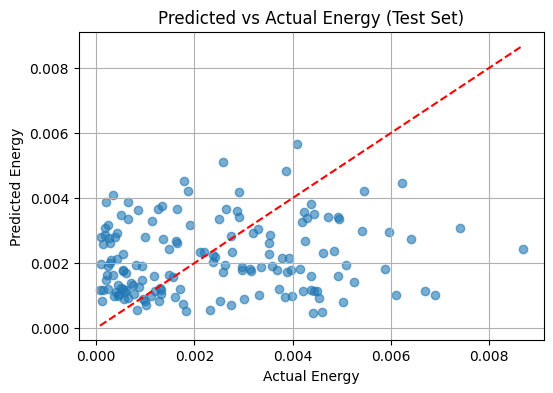

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def train_energy_model(df):
    X = df[['prompt_token_length', 'char_count', 'avg_word_length']].copy()
    y = df['energy_consumption_llm_total'].copy()

    # Log transform (optional)
    y = np.log1p(y)

    # Generate index for tracking
    full_index = df.index
    X_train_val, X_test, y_train_val, y_test, idx_train_val, idx_test = train_test_split(
        X, y, full_index, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    print("Validation MAE:", mean_absolute_error(np.expm1(y_val), np.expm1(y_val_pred)))
    print("Validation R²:", r2_score(np.expm1(y_val), np.expm1(y_val_pred)))
    print("Test MAE:", mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred)))
    print("Test R²:", r2_score(np.expm1(y_test), np.expm1(y_test_pred)))

    print("\nFeature Importances:")
    for name, score in zip(X.columns, model.feature_importances_):
        print(f"{name}: {round(score, 4)}")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(np.expm1(y_test), np.expm1(y_test_pred), alpha=0.6)
    plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))],
             [min(np.expm1(y_test)), max(np.expm1(y_test))], color='red', linestyle='--')
    plt.xlabel("Actual Energy")
    plt.ylabel("Predicted Energy")
    plt.title("Predicted vs Actual Energy (Test Set)")
    plt.grid(True)
    plt.show()

    return model, idx_test

model, test_idx = train_energy_model(df)


We train a Random Forest model to predict how much energy a prompt uses, based on its length and structure. The target is log-transformed for better results. After training, we check how well the model performs on unseen data and visualize the predictions.

### Optimizing Prompts with BART Facebook

In [50]:
from transformers import BartTokenizer, BartForConditionalGeneration
import difflib

# Load BART model and tokenizer
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

def is_too_similar(a, b, threshold=0.95):
    return difflib.SequenceMatcher(None, a.lower(), b.lower()).ratio() > threshold

def optimize_prompt(prompt):
    prompt = prompt.strip()
    if len(prompt.split()) <= 7:
        return prompt  # Skip very short prompts

    # Tokenize input
    inputs = bart_tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)

    # Generate summary
    summary_ids = bart_model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=60,
        length_penalty=2.0,
        early_stopping=True
    )

    # Decode output
    optimized = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True).strip()

    # ✅ Repetition check
    if not optimized or is_too_similar(prompt, optimized):
        return prompt  # Use original if too similar or empty

    return optimized

# ✅ Test example
original = "Explain the core differences between supervised and unsupervised learning models in machine learning."
optimized = optimize_prompt(original)
print("Original:", original)
print("Optimized:", optimized)


Original: Explain the core differences between supervised and unsupervised learning models in machine learning.
Optimized: Explain the core differences between supervised and unsupervised learning models in machine learning. Explain the key differences between the two types of machine learning models and how they are different in terms of training and learning. See more at CNN.com/MachineLearning. Back to the page you


We use the facebook/bart-large-cnn model to shorten prompts without losing meaning. Very short prompts are skipped, and repetitive results are ignored. This helps reduce the length (and ideally, energy usage) of prompts while keeping their intent.

### Comparing Original Prompts vs Optimized Prompts

In [55]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd

# Load SBERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def get_semantic_similarity(original, optimized):
    emb1 = sbert_model.encode(original, convert_to_tensor=True)
    emb2 = sbert_model.encode(optimized, convert_to_tensor=True)
    return float(util.cos_sim(emb1, emb2))

def predict_energy(model, prompt):
    token_length = len(prompt.split())
    char_length = len(prompt)
    avg_word_length = char_length / token_length if token_length > 0 else 0
    features = [[token_length, char_length, avg_word_length]]
    log_prediction = model.predict(features)[0]
    return max(np.expm1(log_prediction), 1e-6)  # Reverse log1p and clamp minimum

def compare_prompts(original, optimized, model, df=None):
    original_energy = predict_energy(model, original)
    optimized_energy = predict_energy(model, optimized)
    similarity = get_semantic_similarity(original, optimized)
    verb_count = df['verb_count'].loc[df['prompt'] == original].values[0] if df is not None else 0
    # Reject if similarity too low
    if similarity < 0.80:
        return {
            "original_prompt": original,
            "optimized_prompt": optimized,
            "original_energy": round(original_energy, 6),
            "optimized_energy": round(original_energy, 6),  # force same
            "energy_saved (%)": 0.0,
            "shortening_coeff": round(len(optimized) / len(original), 2),
            "semantic_similarity": round(similarity, 4),
            "output_confidence": "Rejected (Low Similarity)"
        }

    # Handle cosmetic changes
    if similarity > 0.97 and abs(len(optimized) - len(original)) < 5:
        optimized_energy = original_energy
        energy_saving = 0.0
    else:
        energy_saving = (original_energy - optimized_energy) / original_energy
        if abs(energy_saving) < 0.01:
            energy_saving = 0.0
            optimized_energy = original_energy

    return {
        "original_prompt": original,
        "optimized_prompt": optimized,
        "original_energy": round(original_energy, 6),
        "optimized_energy": round(optimized_energy, 6),
        "energy_saved (%)": round(energy_saving * 100, 2),
        "shortening_coeff": round(len(optimized) / len(original), 2),
        "semantic_similarity": round(similarity, 4),
        "output_confidence": "High" if similarity >= 0.85 else "Low"
    }

# Test call
result = compare_prompts(original, optimized, model)
pd.DataFrame([result])


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,original_prompt,optimized_prompt,original_energy,optimized_energy,energy_saved (%),shortening_coeff,semantic_similarity,output_confidence
0,Explain the core differences between supervise...,Explain the core differences between supervise...,0.002274,0.00231,-1.57,2.95,0.8949,High


This step uses SBERT to check if the optimized prompt is semantically similar to the original. If the similarity is too low, the prompt is rejected. We then use our trained energy model to predict energy usage and calculate:

% Energy Saved

Shortening Coefficient

Confidence in Semantic Match

Only meaningful, non-cosmetic optimizations are accepted.

### Method for saving the optimized prompts into a new dataset

In [60]:
import os

def save_improved_prompts(results_df, source_df, out_path="../data/improved_prompts.csv"):
    # Keep only improved prompts
    improved = results_df[results_df["energy_saved (%)"] > 0].copy()

    # Add token length from optimized prompt
    improved["token_length"] = improved["optimized_prompt"].apply(lambda x: len(str(x).split()))

    # Map verb_count from original df using original_prompt
    if {"prompt", "verb_count"}.issubset(source_df.columns):
        vc_map = source_df.drop_duplicates("prompt").set_index("prompt")["verb_count"]
        improved["verb_count"] = improved["original_prompt"].map(vc_map)
    else:
        improved["verb_count"] = None  # fallback if not available

    # Compute energy_difference
    improved["energy_difference"] = improved["original_energy"] - improved["optimized_energy"]

    # Select and order columns
    final_df = improved[[
        "original_prompt",
        "optimized_prompt",
        "token_length",
        "verb_count",
        "original_energy",
        "optimized_energy",
        "energy_difference"
    ]]

    # Save to CSV
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    final_df.to_csv(out_path, index=False)
    print(f"✅ Saved {len(final_df)} improved prompts to {out_path}")

### Evaluating Prompts on Test Set

In [63]:
def evaluate_test_set_prompts(df, test_idx, model, n=5, random_state=42):
    test_df = df.loc[test_idx].dropna(subset=["prompt"]).copy()
    test_df["prompt"] = test_df["prompt"].astype(str)
    sampled_prompts = test_df["prompt"].sample(n=n, random_state=random_state).tolist()
    
    results = []
    for i, prompt in enumerate(sampled_prompts, 1):
        optimized = optimize_prompt(prompt)
        comparison = compare_prompts(prompt, optimized, model)
        results.append(comparison)

        print(f"\n🔹 Prompt {i}")
        print("Original Prompt: ", comparison["original_prompt"])
        print("Optimized Prompt:", comparison["optimized_prompt"])
        print(f"→ Saved: {comparison['energy_saved (%)']}% | Similarity: {comparison['semantic_similarity']} | Status: {comparison['output_confidence']}")

        if comparison["energy_saved (%)"] > 0:
            print("✅ This prompt was improved!")

    df_results = pd.DataFrame(results)

    # Filtering and metrics
    valid = df_results[df_results["output_confidence"] != "Rejected (Low Similarity)"]
    rejected = len(df_results) - len(valid)
    improved = (valid["energy_saved (%)"] > 0).sum()
    worsened = (valid["energy_saved (%)"] < 0).sum()

    meaningful = valid[valid["energy_saved (%)"] != 0]
    avg_saving_all_valid = valid["energy_saved (%)"].mean()
    avg_saving_meaningful = meaningful["energy_saved (%)"].mean()

    print(f"\n📊 Summary on {n} Prompts:")
    print(f"✔️ Valid Optimizations: {len(valid)}")
    print(f"❌ Rejected: {rejected}")
    print(f"✅ Improved: {improved}")
    print(f"⚠️ Worsened: {worsened}")
    print(f"💡 Avg Net Energy Saved (All Valid): {round(avg_saving_all_valid, 2)}%")
    print(f"💡 Avg Net Energy Saved (Excl. 0% cases): {round(avg_saving_meaningful, 2)}%")

    # Save improved prompts with verb_count pulled from df
    save_improved_prompts(valid, source_df=df)

    return df_results

# Run evaluation
results_df = evaluate_test_set_prompts(df, test_idx, model, n=154)
results_df

c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 1
Original Prompt:  What is the main benefit of using a natural language processing (NLP) system? 
Optimized Prompt: What is the main benefit of using a natural language processing (NLP) system? What are the main benefits of using an NLP system? Share your thoughts with us in the comments below or email us at editorial@dailymailonline.co.uk.
→ Saved: 29.59% | Similarity: 0.8367 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 2
Original Prompt:  Create a 5-item shopping list for a healthy breakfast. 
Optimized Prompt: Create a 5-item shopping list for a healthy breakfast. Create a list of five items to help you get a healthy start to the day. Share your healthy breakfast ideas with CNN iReport in the comments below. For more information, visit CNN.com/breakfast.
→ Saved: 46.05% | Similarity: 0.89 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 3
Original Prompt:  Rearrange the words to create a complete sentence. Underwater creatures are fascinating
Optimized Prompt: Rearrange the words to create a complete sentence. Underwater creatures are fascinating, according to the author of a new book about underwater creatures. The author of the book, The Underwater World, says that the underwater world is fascinating. The book is published by Simon &
→ Saved: 22.9% | Similarity: 0.8234 | Status: Low
✅ This prompt was improved!

🔹 Prompt 4
Original Prompt:  Predict the weather in Los Angeles tomorrow. 
Optimized Prompt: Predict the weather in Los Angeles tomorrow.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 5
Original Prompt:  Generate a 1-sentence summary on the following news article. The Tokyo Olympic Games will be postponed to 2021 due to the worldwide outbreak of Covid-19.
Optimized Prompt: The Tokyo Olympic Games will be postponed to 2021 due to the worldwide outbreak of Covid-19. The games will be held in Tokyo, Japan, in 2020 and in Yokohama, Japan in 2021. The Olympic Games were originally scheduled for Tokyo in 1964 and 1964.
→ Saved: 0.0% | Similarity: 0.7154 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 6
Original Prompt:  Create a list of items for a picnic. 
Optimized Prompt: Create a list of items for a picnic. Create a picnic list of things to take with you to your next picnic. Share your picnic ideas with your friends and family on social media. Share photos of your picnic with us on Facebook and Twitter. Visit CNN.com/s
→ Saved: 0.0% | Similarity: 0.7924 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 7
Original Prompt:  Analyze the following political statement and determine its accuracy. Many people agree that the current president has been a successful leader.
Optimized Prompt: Analyze the following political statement and determine its accuracy. Many people agree that the current president has been a successful leader. The statement was made in response to a question about the state of the U.S. economy. The answer was that the economy was in good shape and that the
→ Saved: -17.62% | Similarity: 0.8717 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 8
Original Prompt:  Create a survey question to measure customer satisfaction 
Optimized Prompt: Create a survey question to measure customer satisfaction. Create a survey to test your knowledge of your customers' satisfaction with your products and services. Use the questions below to help you understand your customer's satisfaction with products and customer service. Visit www.surveymonkey.com/s
→ Saved: 21.68% | Similarity: 0.8329 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 9
Original Prompt:  Generate a question based on the following input. Humans are the dominant species on Earth.
Optimized Prompt: Generate a question based on the following input. Humans are the dominant species on Earth. What do you think? Share your thoughts in the comments below or tweet us @CNNOpinion. Back to Mail Online home. Back To the page you came from. Click here for more
→ Saved: 69.26% | Similarity: 0.9052 | Status: High
✅ This prompt was improved!

🔹 Prompt 10
Original Prompt:  Explain the uses of artificial intelligence. 
Optimized Prompt: Explain the uses of artificial intelligence.
→ Saved: 0.0% | Similarity: 1.0 | Status: High

🔹 Prompt 11
Original Prompt:  Summarize the industrial revolution. 
Optimized Prompt: Summarize the industrial revolution.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 12
Original Prompt:  Pick out the odd word out in each sentence: Tree, Wind, Flower
Optimized Prompt: Pick out the odd word out of each sentence: Tree, Wind, Flower. Pick out the word that sounds like a tree in each of these sentences: Wind, Tree, Flower, Tree. Pick the word out in each sentence that looks like a wind, tree, wind,
→ Saved: 42.42% | Similarity: 0.8887 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 13
Original Prompt:  Find a rhyming word for the word "river". 
Optimized Prompt: Find a rhyming word for the word "river" to rhyme with. Find a word that rhymes with " river" to find a word for "river". Find a rhymed word for 'river' to rhymed with ' river' to find the word '
→ Saved: 19.86% | Similarity: 0.8618 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 14
Original Prompt:  Evaluate the following statement AI is the new electricity.
Optimized Prompt: Evaluate the following statement AI is the new electricity: "AI is thenew electricity" AI is a form of artificial intelligence that can be used to create new forms of energy. AI can also be used as a way to create a new form of energy called "energ
→ Saved: 57.41% | Similarity: 0.857 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 15
Original Prompt:  Print all the prime numbers between 1 and 50. 
Optimized Prompt: Print all the prime numbers between 1 and 50. Print all theprime numbers from 1 to 50. Click here for more information on how to print your own prime numbers. Back to Mail Online home. Back into the page you came from. Back To The page you come from.
→ Saved: 67.91% | Similarity: 0.8895 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 16
Original Prompt:  Perform a sentiment analysis on the given sentence. I love this movie!
Optimized Prompt: Perform a sentiment analysis on the given sentence. I love this movie! I love the movie. I like the movie, but I don't want to watch it. I want to go to the movie theater. I'm not going to watch the movie in the theater.
→ Saved: 0.0% | Similarity: 0.6533 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 17
Original Prompt:  Provide an example of how AI can solve a problem. 
Optimized Prompt: Provide an example of how AI can solve a problem. Show how it can be used to improve the quality of life for people in your community. Use the example below to show how AI could be used in your own life to improve your quality of living. Back to Mail Online home
→ Saved: 0.0% | Similarity: 0.7875 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 18
Original Prompt:  Choose an appropriate introduction for the following news article. The latest report from the Environmental Protection Agency reveals that the emissions of greenhouse gasses in the state have risen by 5% from last year.
Optimized Prompt: The emissions of greenhouse gasses in the state have risen by 5% from last year. The latest report from the Environmental Protection Agency reveals that the emissions are up by 5%. The state's greenhouse gas emissions are now at their highest level since records began in the 1970s.
→ Saved: -19.78% | Similarity: 0.8287 | Status: Low


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 19
Original Prompt:  Devise a strategic plan for a fashion brand to increase its online presence. 
Optimized Prompt: Devise a strategic plan for a fashion brand to increase its online presence. Devise a plan for the brand's online presence to boost its online sales. Develop a strategy to increase the brand’s social media presence to increase sales. Create a strategy for the fashion brand
→ Saved: 38.68% | Similarity: 0.9127 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 20
Original Prompt:  What is the gravitational potential energy of a 5-kilogram object at height 10 meters? 
Optimized Prompt: What is the gravitational potential energy of a 5-kilogram object at height 10 meters? The answer is: It's a lot of gravitational potential. The answer: A lot of energy. What is it? It's an object that is 10 meters tall. It has a gravitational
→ Saved: 43.47% | Similarity: 0.9268 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 21
Original Prompt:  Name all the elements in the periodic table with symbol C. 
Optimized Prompt: Name all the elements in the periodic table with symbol C. Name all of the elements with symbol A. Name the elements that have been added to the periodic tables since the discovery of the C-pointed star in 1881. Name every element that has been added since 1881 with
→ Saved: 62.79% | Similarity: 0.8251 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 22
Original Prompt:  Search the web and find the title of the longest novel. 
Optimized Prompt: Search the web and find the title of the longest novel. The longest novel is the longest book ever written. It was written by William Faulkner and published in 1881. The book is called "The Longest Novel" and is written in the form of a series of
→ Saved: 17.19% | Similarity: 0.8 | Status: Low
✅ This prompt was improved!

🔹 Prompt 23
Original Prompt:  Name a planet from our solar system. 
Optimized Prompt: Name a planet from our solar system.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 24
Original Prompt:  Come up with 2 key questions related to this article. CNN's consultant on political television advertising believes that the cost to influence the 2008 election may exceed $3 billion.
Optimized Prompt: CNN's consultant on political television advertising believes that the cost to influence the 2008 election may exceed $3 billion.Come up with two key questions related to this article. Come up with a question about the campaign that you think should be asked of the candidates and their surrogates.
→ Saved: -41.09% | Similarity: 0.9657 | Status: High

🔹 Prompt 25
Original Prompt:  What type of number is -625? 
Optimized Prompt: What type of number is -625?
→ Saved: 0.0% | Similarity: 1.0 | Status: High

🔹 Prompt 26
Original Prompt:  Generate a limerick poem about a lemur. 
Optimized Prompt: Generate a limerick poem about a lemur.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 27
Original Prompt:  Rewrite the following sentence using the root words. I am not feeling well.
Optimized Prompt: Rewrite the following sentence using the root words. I am not feeling well. Rewrite it again to say I am feeling sick. The root words are "I am not well" and "I'm not feeling good" The root word is "I" and the root word
→ Saved: 0.0% | Similarity: 0.774 | Status: Rejected (Low Similarity)

🔹 Prompt 28
Original Prompt:  Explain what is an algorithmic trading. 
Optimized Prompt: Explain what is an algorithmic trading.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 29
Original Prompt:  Identify a potential security threat for a global online financial system. 
Optimized Prompt: Identify a potential security threat for a global online financial system. Identify a Potential Security Threat for a Global Online Financial System. For confidential support call the Samaritans on 08457 90 90 90 or visit a local Samaritans branch, see www.samaritans.org for details
→ Saved: 0.0% | Similarity: 0.7933 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 30
Original Prompt:  Sort the following numbers in ascending order: 12, 26, 83, 19. 
Optimized Prompt: Sort the following numbers in ascending order: 12, 26, 83, 19, 19. Sort the numbers in descending order: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
→ Saved: 27.05% | Similarity: 0.9504 | Status: High
✅ This prompt was improved!

🔹 Prompt 31
Original Prompt:  Describe the process of osmosis. 
Optimized Prompt: Describe the process of osmosis.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 32
Original Prompt:  Generate a paragraph based on the given information. In the year 2025, the United Nations is working hard to reduce its carbon emissions by 50%.
Optimized Prompt: Generate a paragraph based on the given information. In the year 2025, the United Nations is working hard to reduce its carbon emissions by 50%. For more information, go to: http://www.nations.org/carbon-emissions-by-2025.
→ Saved: 15.34% | Similarity: 0.9756 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 33
Original Prompt:  Rewrite the following sentence in the third person I am anxious
Optimized Prompt: Rewrite the following sentence in the third person I am anxious. Rewrite it in the second person I'm anxious.Rewrite it again in the first person I was anxious. I'm an anxious person. I am not anxious about anything. I just want to know what
→ Saved: 62.77% | Similarity: 0.8053 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 34
Original Prompt:  Come up with an interesting title for this article about artificial intelligence. The article
Optimized Prompt: Come up with an interesting title for this article about artificial intelligence. The article is about the development of artificial intelligence in the world of computers. For more information on artificial intelligence, go to: http://www.academyofartificialintelligence.org/artificial-intelligence.
→ Saved: -21.59% | Similarity: 0.8466 | Status: Low

🔹 Prompt 35
Original Prompt:  Describe the structure of an atom. 
Optimized Prompt: Describe the structure of an atom.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 36
Original Prompt:  For the given artist, name three of their famous works. Salvador Dali
Optimized Prompt: For the given artist, name three of their famous works. Salvador Dali is one of the most famous artists of the 20th century. For Dali, the name of one of his famous works is "Salvador Dali" The name of the other artist is "
→ Saved: 56.66% | Similarity: 0.8694 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 37
Original Prompt:  Write a review for the following movie. The Godfather
Optimized Prompt: Write a review for the following movie. The Godfather is available on Blu-ray and DVD in the U.S. and Canada. For more information on how to order your copy of the Godfather, visit www.amazon.com/Godfather-The-God
→ Saved: 0.0% | Similarity: 0.6253 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 38
Original Prompt:  Give a possible explanation for recent declines in pollinator populations. 
Optimized Prompt: Give a possible explanation for recent declines in pollinator populations. Give a possible reason for the decline of pollinator numbers in the U.S. Tell us what you think is the cause of the decline in pollinators in your area. Share your thoughts on pollinator declines in
→ Saved: 44.93% | Similarity: 0.8083 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 39
Original Prompt:  Given a list of six grocery items, select the two most expensive items eggs, flour, milk, bananas, cherries, coffee
Optimized Prompt: Given a list of six grocery items, select the two most expensive items. Eggs, flour, milk, bananas, cherries, coffee are the most expensive. The most expensive item is eggs, flour and milk, followed by bananas and cherries. The least expensive items are eggs,
→ Saved: -14.48% | Similarity: 0.8815 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 40
Original Prompt:  Edit the following sentence to remove all passive voice. The thesis was written by the student.
Optimized Prompt: Edit the following sentence to remove all passive voice. The thesis was written by the student. The student wrote the thesis for his senior thesis. For more information on the student's thesis, visit his website: http://www.thestudent.com/sophomore-thesis
→ Saved: -42.85% | Similarity: 0.8956 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 41
Original Prompt:  Rewrite the following sentence using active voice. The news report was read by the captain.
Optimized Prompt: Rewrite the following sentence using active voice. The news report was read by the captain. The captain read the news report from the front of the team. The report was written by the team's sports editor. The editor then read the report back to the team from the back.
→ Saved: 70.97% | Similarity: 0.8656 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 42
Original Prompt:  Calculate the area of a triangle with sides measuring 8cm, 5cm, and 6cm. 
Optimized Prompt: Calculate the area of a triangle with sides measuring 8cm, 5cm, and 6cm. Calculation based on the size of the triangle and the number of sides on each side. For more information, go to: http://www.cnn.com/2013/
→ Saved: 37.32% | Similarity: 0.8441 | Status: Low
✅ This prompt was improved!

🔹 Prompt 43
Original Prompt:  Describe the 1981 NBA MVP award ceremony 
Optimized Prompt: Describe the 1981 NBA MVP award ceremony
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 44
Original Prompt:  Classify the following words by their grammatical categories: walk, interesting, quickly 
Optimized Prompt: Classify the following words by their grammatical categories: walk, interesting, quickly, quickly. Classify the word "walk" by its grammatical category: interesting, quick, interesting. Classifies the word "walk" as a word that means "to walk quickly"
→ Saved: -18.27% | Similarity: 0.9306 | Status: High

🔹 Prompt 45
Original Prompt:  Explain what an API is. 
Optimized Prompt: Explain what an API is.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 46
Original Prompt:  Analyze the given poem and explain the theme. Roses are red, 
Violets are blue, 
Sugar is sweet 
And so are you.
Optimized Prompt: Analyze the given poem and explain the theme. Roses are red, violets are blue, sugar is sweet, and so are you. Analyze the poem to understand the theme of this week's Daily Discussion. The Daily Discussion is open to the public. For more information,
→ Saved: 19.57% | Similarity: 0.9127 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 47
Original Prompt:  Generate 3 marketing ideas to increase engagement on a product's social media account. 
Optimized Prompt: Generate 3 marketing ideas to increase engagement on a product's social media account. Generate three marketing ideas for a product on Facebook, Twitter or Instagram. Use these three ideas to create a social media campaign for your product or service. For more information on these ideas, visit www
→ Saved: 18.42% | Similarity: 0.9328 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 48
Original Prompt:  Find the sum of the sides of the following triangle. Triangle ABC has sides AB = 5 cm, BC = 6 cm, and AC = 7 cm.
Optimized Prompt: Triangle ABC has sides AB = 5 cm, BC = 6 cm, and AC = 7 cm. Find the sum of the sides of the following triangle. Triangle ABC is a triangle with sides AB, BC, AC, and F = 5, 6, and 7cm.
→ Saved: 48.77% | Similarity: 0.9319 | Status: High
✅ This prompt was improved!

🔹 Prompt 49
Original Prompt:  How does the human brain remember information? 
Optimized Prompt: How does the human brain remember information?
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 50
Original Prompt:  Calculate the area of a triangle with the following sides: 10, 14, 8. 
Optimized Prompt: Calculate the area of a triangle with the following sides: 10, 14, 8. The area of the triangle can be calculated by multiplying the sides by 10. For example, the triangle would have an area of 10 times 10 times 14 times 8. For more information, visit
→ Saved: 14.41% | Similarity: 0.9116 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 51
Original Prompt:  Generate a sentence that contains the given words. magic, castle, king
Optimized Prompt: Generate a sentence that contains the given words. magic, castle, king is the first word in the sentence. The second word is the word for the castle. The third word is for the king. The fourth and final word is called the king and is the last word.
→ Saved: 74.3% | Similarity: 0.8988 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 52
Original Prompt:  Write a scientific explanation for why the sky is blue. 
Optimized Prompt: Write a scientific explanation for why the sky is blue. Write an explanation of why the sun is blue and why the moon is red. Write a scientific answer to the question: Why is the sky blue? Write a science explanation for the sky being blue. Share your answers in
→ Saved: 61.64% | Similarity: 0.8503 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 53
Original Prompt:  Identify the time complexity of the Insertion Sort algorithm. 
Optimized Prompt: Identify the time complexity of the Insertion Sort algorithm. Identify the complexity of each step in the algorithm. Use this information to help you understand the algorithm's complexity. Use the algorithm to understand how to use the algorithm in the real world. Back to Mail Online home.
→ Saved: 0.0% | Similarity: 0.7291 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 54
Original Prompt:  Analyze the given film and explain why it should be included in the top 10 list. The film Parasite
Optimized Prompt: Analyze the given film and explain why it should be included in the top 10 list. The film Parasite is one of the most popular films of all time, according to IMDB.com. It has been in cinemas for more than 30 years and has won numerous awards.
→ Saved: -33.3% | Similarity: 0.8312 | Status: Low


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 55
Original Prompt:  Read the following story and decide if it is fiction or non-fiction. A farmer grows a mysterious flower overnight. The farmer is amazed and decides to sell the plant in the market. People from far and wide visit the farmer's market to get a glimpse of the miraculous flower.
Optimized Prompt: A farmer grows a mysterious flower overnight. The farmer is amazed and decides to sell the plant in the market. People from far and wide visit the farmer's market to get a glimpse of the miraculous flower.Read the following story and decide if it is fiction or non-fiction.
→ Saved: 0.0% | Similarity: 0.9808 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 56
Original Prompt:  Provide a topic for the following passage The vegan diet is becoming increasingly popular, as an increasing number of people are making the switch for environmental, ethical, and health reasons. People on a vegan diet consume only plant-based foods, such as fruits, vegetables, grains, nuts, and seeds. Veganism has also become popular with athletes, as many have discovered that a rich and varied vegan diet can help them reach their fitness goals.
Optimized Prompt: The vegan diet is becoming increasingly popular, as an increasing number of people are making the switch for environmental, ethical, and health reasons. People on a vegan diet consume only plant-based foods, such as fruits, vegetables, grains, nuts, and seeds. Veganism has also become
→ Saved: -87.47% | Similarity: 0.9144 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 57
Original Prompt:  Write 3 facts about the Tour de France 
Optimized Prompt: Write 3 facts about the Tour de France. Read 3 facts on the Tour's history. Read more about the history of cycling in France with our guide to the Tour. Write 3 facts for us about the 2013 Tour deFrance. Visit TourdeFrance.com for more information
→ Saved: 0.0% | Similarity: 0.6366 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 58
Original Prompt:  Specify the filename for the following document. The document contains instructions on how to set up a home Wi-Fi network.
Optimized Prompt: The document contains instructions on how to set up a home Wi-Fi network.Specify the filename for the following document. The document is intended to be a guide to setting up your own Wi- Fi network. For more information, visit the Wi-fi Networking Guide.
→ Saved: 29.33% | Similarity: 0.9103 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 59
Original Prompt:  Generate a headline for a story about the death of a famous actor. Actor: Will Smith
Optimized Prompt: Generate a headline for a story about the death of a famous actor. Will Smith: Will Smith died at the age of 50. Will be remembered for his role in the film "The Godfather" Will Smith was also known for his roles in "Miami Vice" and "The
→ Saved: 0.0% | Similarity: 0.6868 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 60
Original Prompt:  Make a list of different types of cryptocurrencies. 
Optimized Prompt: Make a list of different types of cryptocurrencies. Make a list on how many types of cryptocurrency there are. See the list below for more information on each type of cryptocurrency. For more information, go to: www.crowdfunds.org.uk/crowds
→ Saved: 0.0% | Similarity: 0.7494 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 61
Original Prompt:  Calculate the total surface area of a cube with a side length of 5 cm. 
Optimized Prompt: Calculate the total surface area of a cube with a side length of 5 cm. Calculation is based on the size of the cube and its side length. For example, the cube has a size of 5cm by 5cm. For a cube of the same size, the
→ Saved: 27.83% | Similarity: 0.9136 | Status: High
✅ This prompt was improved!

🔹 Prompt 62
Original Prompt:  Describe a type of bird 
Optimized Prompt: Describe a type of bird
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 63
Original Prompt:  Outline the key differences between the Linux and Windows operating systems. 
Optimized Prompt: Outline the key differences between the Linux and Windows operating systems. Outline thekey differences between Windows and Linux operating systems in the latest Windows 8.1 software update. The latest version of the Windows 8 software update is available on the Microsoft Windows 8 operating system.
→ Saved: 0.0% | Similarity: 0.7826 | Status: Rejected (Low Similarity)

🔹 Prompt 64
Original Prompt:  Explain what is a neural network 
Optimized Prompt: Explain what is a neural network
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 65
Original Prompt:  Determine a price point for the item. Widget
Optimized Prompt: Determine a price point for the item. Widget help you with reading comprehension and vocabulary. Use the weekly Newsquiz to test your knowledge of stories you saw on CNN.com. For more information on CNN's iReport, visit the newsquiz.com page.
→ Saved: 0.0% | Similarity: 0.4716 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 66
Original Prompt:  Come up with a catchy and witty headline for the following article. CNN's consultant on political television advertising believes that the cost to influence the 2008 election may exceed $3 billion.
Optimized Prompt: CNN's consultant on political television advertising believes that the cost to influence the 2008 election may exceed $3 billion.Come up with a catchy and witty headline for the following article. Click here to read the article in its original form. The article was originally published on CNN.com.
→ Saved: -41.1% | Similarity: 0.9759 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 67
Original Prompt:  Transcribe the recording into text. Recording about the history of Waterloo
Optimized Prompt: Transcribe the recording into text. Recording about the history of Waterloo. Recordings of events in the city of Waterloo in the 19th century. Records of events from the time of Queen Victoria to the present day. Records from the era of Queen Elizabeth II to the current day.
→ Saved: -12.51% | Similarity: 0.8157 | Status: Low


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 68
Original Prompt:  Classify the following fruit according to its color. Orange
Optimized Prompt: Classify the following fruit according to its color. Orange is the most common fruit of the orange family. Orange fruit is also known as an orange-coloured fruit. Orange fruits can also be found in red, blue, yellow, and white. They are usually found in the
→ Saved: 0.0% | Similarity: 0.7862 | Status: Rejected (Low Similarity)

🔹 Prompt 69
Original Prompt:  Create a story about a parrot. 
Optimized Prompt: Create a story about a parrot.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 70
Original Prompt:  Rewrite this sentence in the present tense She had cooked
Optimized Prompt: Rewrite this sentence in the present tense She had cooked. Rewrite it in the past tense to make it clear that she had cooked the meal. She had not cooked the food, she had made it. She was cooking the food. She'd cooked it herself. She
→ Saved: 58.64% | Similarity: 0.8249 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 71
Original Prompt:  Analyze the given sentence and identify its grammatical errors, if any. These type of problems are difficult to solve.
Optimized Prompt: Analyze the given sentence and identify its grammatical errors, if any. These type of problems are difficult to solve. Analyze the sentence to see if there are any errors in the grammar. If there are, try to fix the errors by changing the word or phrase.
→ Saved: 30.6% | Similarity: 0.8652 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 72
Original Prompt:  Create a dialogue between two colleagues discussing a project they are working on. 
Optimized Prompt: Create a dialogue between two colleagues discussing a project they are working on. Use the weekly Newsquiz to test your knowledge of stories you saw on CNN.com. Today's newsquiz includes questions and answers from readers of this blog. The question of the day: What do you
→ Saved: 0.0% | Similarity: 0.5021 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 73
Original Prompt:  Identify the most suitable adverb for the following sentence She works
Optimized Prompt: Identify the most suitable adverb for the following sentence She works. She works is the most common adverb used to describe a person. The word "she" is often used to refer to a person who has worked hard to achieve a goal. For example, "she works"
→ Saved: 72.06% | Similarity: 0.8505 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 74
Original Prompt:  What is the product of 6 and 2? 
Optimized Prompt: What is the product of 6 and 2? What is the difference between 6 and 1? What are the differences between the two versions of the word "six" and "two"? What are they? What do they have in common with each other? What's the difference?
→ Saved: 32.03% | Similarity: 0.8126 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 75
Original Prompt:  Generate a valid username given a set of user information. Name: Sarah Jones, Age: 34
Optimized Prompt: Generate a valid username given a set of user information. Name: Sarah Jones, Age: 34. Generation of a username is based on a user's name, age and location. Generate a username from a list of user names and passwords. Generating a username based on
→ Saved: 51.9% | Similarity: 0.9461 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 76
Original Prompt:  Design a logo for a restaurant that serves traditional Chinese dishes. 
Optimized Prompt: Design a logo for a restaurant that serves traditional Chinese dishes. Design a logo to represent a Chinese restaurant's traditional Chinese food. Design your own logo for your own restaurant's logo. For more information on how to design a restaurant logo, visit CNN.com/Design.
→ Saved: 49.8% | Similarity: 0.8617 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 77
Original Prompt:  Analyze the historical significance of the Stonewall Uprising. 
Optimized Prompt: Analyze the historical significance of the Stonewall Uprising. Analyze the history of the Uprising in the U.S. and the role of the Confederate States of America in it. Analyse the history and role of Confederate soldiers in the United States and around the world.
→ Saved: 53.97% | Similarity: 0.8311 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 78
Original Prompt:  Construct a list of tips to help reduce stress. 
Optimized Prompt: Construct a list of tips to help reduce stress. Construct a list to help you reduce stress with these tips. Use these tips to reduce stress in your own life and in others' lives. For more tips on reducing stress, visit CNN.com/StressReduce.
→ Saved: 0.0% | Similarity: 0.7757 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 79
Original Prompt:  Describe the solution in detail. We established a system for automatically generating data for our machine learning model.
Optimized Prompt: Describe the solution in detail. We established a system for automatically generating data for our machine learning model. Describe the system in detail and how it was used to generate data for the model. We created a system to automatically generate data to help train our machinelearning model.
→ Saved: 36.18% | Similarity: 0.9225 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 80
Original Prompt:  Given a sentence, convert it into passive voice. The dog barked at the alley cat.
Optimized Prompt: Given a sentence, convert it into passive voice. The dog barked at the alley cat. The alley cat barked back at the dog. The dogs barked again. The cats barked and ran away. The cat ran away from the dog and the dog ran after it
→ Saved: 8.94% | Similarity: 0.8985 | Status: High
✅ This prompt was improved!

🔹 Prompt 81
Original Prompt:  Compose a tweet about successful teamwork 
Optimized Prompt: Compose a tweet about successful teamwork
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 82
Original Prompt:  Translate the phrase "I love you" into Spanish. 
Optimized Prompt: Translate the phrase "I love you" into Spanish. Translate the word "I'm in love" into the Spanish version of the phrase. Translate the phrase into the English version of "I Love You" into "I am in love with you"
→ Saved: 20.2% | Similarity: 0.8957 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 83
Original Prompt:  Design a logo for a website about recycling. 
Optimized Prompt: Design a logo for a website about recycling. Use the logo to help people with their recycling efforts. The logo will be part of the website's look and feel. For more information on the logo, visit www.recycling.org.uk. For a logo about recycling, visit
→ Saved: 32.42% | Similarity: 0.8242 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 84
Original Prompt:  Write a product description for a new mobile. iPhone 11 Pro
Optimized Prompt: Write a product description for a new mobile. iPhone 11 Pro. Write a description of a new phone or tablet for the first time. Share your photos, videos and more with CNN iReport. Send your photos and videos to jennifer.smith@dailymail.co
→ Saved: 50.25% | Similarity: 0.8614 | Status: High
✅ This prompt was improved!

🔹 Prompt 85
Original Prompt:  Explain what a computer algorithm is. 
Optimized Prompt: Explain what a computer algorithm is.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 86
Original Prompt:  Split the following sentence into two separate sentences. He said hello and waved goodbye.
Optimized Prompt: Split the following sentence into two separate sentences. He said hello and waved goodbye. He also said goodbye and said hello again. He then said goodbye again and said he would see you later. He waved goodbye and then said hello to his friends and family. He did not say goodbye
→ Saved: 77.84% | Similarity: 0.8112 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 87
Original Prompt:  Explain how neural networks can be used to predict stock prices. 
Optimized Prompt: Explain how neural networks can be used to predict stock prices. Explain how they can help predict the future of a company's stock price. See more at CNN.com/soulmatestories and follow us on Twitter @cnnstories and @jennifer
→ Saved: 32.85% | Similarity: 0.8594 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 88
Original Prompt:  Generate a short story about a scientist in a lab. 
Optimized Prompt: Generate a short story about a scientist in a lab. Use the weekly Newsquiz to test your knowledge of stories you saw on CNN.com. Today's newsquiz includes a question about a story you saw in the news. Submit your answer at the bottom of the page
→ Saved: 0.0% | Similarity: 0.7243 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 89
Original Prompt:  Provide me a list of diseases that can be caused by smoking. 
Optimized Prompt: Provide me a list of diseases that can be caused by smoking. I'll give you a list. Tell me what they are. I want to know. I don't want to hear about them. I just want you to tell me what you're sick of smoking.
→ Saved: 66.75% | Similarity: 0.8155 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 90
Original Prompt:  Provide an explanation why this opinion is wrong. Driverless cars will make travel safer.
Optimized Prompt: Provide an explanation why this opinion is wrong. Driverless cars will make travel safer, says the U.S. National Institute of Standards and Technology (NIST) NIST is an independent, non-profit organisation based in Washington, D.C. NIST's mission is
→ Saved: 0.0% | Similarity: 0.7484 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 91
Original Prompt:  Correct any spelling or grammar mistakes in the given sentence. She jogged excersies around the lake.
Optimized Prompt: Correct any spelling or grammar mistakes in the given sentence. She jogged excersies around the lake. She went for a walk in the park. She took a nap in the sun. She had a glass of wine in the afternoon. She played with her friends in the garden.
→ Saved: 0.0% | Similarity: 0.7728 | Status: Rejected (Low Similarity)

🔹 Prompt 92
Original Prompt:  Create a rule for proper hand-washing technique. 
Optimized Prompt: Create a rule for proper hand-washing technique.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 93
Original Prompt:  Provide an example of a non-renewable source of energy. 
Optimized Prompt: Provide an example of a non-renewable source of energy that is not renewable. For more information, go to: http://www.cnn.com/2013/01/30/energy/energy-news/stories/stories-of-the-
→ Saved: 46.87% | Similarity: 0.888 | Status: High
✅ This prompt was improved!

🔹 Prompt 94
Original Prompt:  How can we reduce air pollution? 
Optimized Prompt: How can we reduce air pollution?
→ Saved: 0.0% | Similarity: 1.0 | Status: High

🔹 Prompt 95
Original Prompt:  List five steps for comparing two products. 
Optimized Prompt: List five steps for comparing two products.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 96
Original Prompt:  Identify the theme of the following book. The book is about a small town in the Midwest and how people respond to a series of tragedies and unexpected events that shake their lives.
Optimized Prompt: Identify the theme of the following book. The book is about a small town in the Midwest and how people respond to a series of tragedies and unexpected events that shake their lives. It is about the people of a small Midwest town and how they respond to the events in their lives
→ Saved: 29.62% | Similarity: 0.9885 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 97
Original Prompt:  Additionally, give me a entertaining story about a conversation with a stranger on a bus. 
Optimized Prompt: Additionally, give me a entertaining story about a conversation with a stranger on a bus. Give me a story about an encounter you had with a total stranger. Tell us about it in the comments section below. I'll feature the best in my next column. Thanks for your time.
→ Saved: 70.52% | Similarity: 0.8883 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 98
Original Prompt:  Provide the lyrics for the song titled “Yesterday” 
Optimized Prompt: Provide the lyrics for the song titled “Yesterday’s” title. Provide the lyrics to the song “ yesterday” for the album “Today.’’ The album is out now on iTunes and Amazon.com. For more information on
→ Saved: 0.0% | Similarity: 0.7999 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 99
Original Prompt:  In this task, you need to identify the source of the sentence from the choices below.

Output should be chosen from:
- Newspaper
- Textbook
- Online article
- Encyclopedia He was a Roman statesman and philosopher who is considered one of the greatest military commanders in history.
Optimized Prompt: In this task, you need to identify the source of the sentence from the choices below.Output should be chosen from: Newspaper, Textbook, Online article, Encyclopedia. He was a Roman statesman and philosopher who is considered one of the greatest military commanders in history.
→ Saved: 6.3% | Similarity: 0.9939 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 100
Original Prompt:  Price the following item. A limited edition, handmade wooden toy truck
Optimized Prompt: Price the following item. A limited edition, handmade wooden toy truck. The truck will be sold in a limited edition handmade wooden box. The box will contain a limited number of the wooden toys. The price of the toy truck is not included in the price of this item.
→ Saved: 73.55% | Similarity: 0.8114 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 101
Original Prompt:  Find the lowest common multiple of two numbers. 36 and 87
Optimized Prompt: Find the lowest common multiple of two numbers. 36 and 87 is the number of the number 36. Find the number 87 by looking at the first two digits in the numerator and the last two numbers in the denominator. 36 is the most common number in the number 16.
→ Saved: 66.48% | Similarity: 0.8805 | Status: High
✅ This prompt was improved!

🔹 Prompt 102
Original Prompt:  List five advantages of using solar energy. 
Optimized Prompt: List five advantages of using solar energy.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 103
Original Prompt:  Convert the money value to USD. 2.30 euros
Optimized Prompt: Convert the money value to USD. 2.30 euros. Convert the moneyvalue toUSD. 1.50 euros. convert the moneyValue to USD 1.00 euro. convert it toUSD 1.10 euro. Convert it to USD 2.10 euros.
→ Saved: -13.5% | Similarity: 0.8482 | Status: Low


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 104
Original Prompt:  Do data normalization on given data set. [1, -1, 0.5, -0.5, 0.8, -0.9, 0.4]
Optimized Prompt: Do data normalization on given data set. [1, -1, 0.5, -0.8, - 0.9,0.4] Do data normalisation on givenData set. Do datanormalization onGivenDataSet. DoDataNormalization on Given
→ Saved: -24.95% | Similarity: 0.8417 | Status: Low


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 105
Original Prompt:  List four strategies for teaching children to read. 
Optimized Prompt: List four strategies for teaching children to read. List four ways to teach children how to read, including reading comprehension and vocabulary. List three ways to help children learn to read and three ways of teaching them to write. List two ways to learn how to write and one way to
→ Saved: 0.0% | Similarity: 0.7454 | Status: Rejected (Low Similarity)

🔹 Prompt 106
Original Prompt:  Compute the derivative of 2x^2 + 5x. 
Optimized Prompt: Compute the derivative of 2x^2 + 5x.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 107
Original Prompt:  Given the following sentence, rewrite it by removing the passive form Organic waste is being recycled for composting.
Optimized Prompt: Given the following sentence, rewrite it by removing the passive form Organic waste is being recycled for composting. For example, rewrite the sentence as follows: "Organic waste is recycled for composting" The passive form is removed and the active form is added
→ Saved: 40.32% | Similarity: 0.9457 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 108
Original Prompt:  Categorize the following items as either furniture or kitchen items. Chair, Knife, Fork
Optimized Prompt: Categorize the following items as either furniture or kitchen items. Chair, Knife, Fork is a chair, knife or fork. Knife is a fork or knife. Knife or fork is a knife or a knife. Chair is a kitchen chair or a kitchen knife. Fork is
→ Saved: 54.37% | Similarity: 0.932 | Status: High
✅ This prompt was improved!

🔹 Prompt 109
Original Prompt:  How did Julius Caesar die? 
Optimized Prompt: How did Julius Caesar die?
→ Saved: 0.0% | Similarity: 1.0 | Status: High

🔹 Prompt 110
Original Prompt:  What is an AI algorithm? 
Optimized Prompt: What is an AI algorithm?
→ Saved: 0.0% | Similarity: 1.0 | Status: High

🔹 Prompt 111
Original Prompt:  Generate a list of present continuous verbs. 
Optimized Prompt: Generate a list of present continuous verbs.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 112
Original Prompt:  Write a 200-word essay explaining the importance of sustainable energy. 
Optimized Prompt: Write a 200-word essay explaining the importance of sustainable energy. Write a 200 word essay explaining why you think sustainable energy is important to the future of the world's energy supply. Share your thoughts in the comments below or email us at editorial@dailymail.co.uk
→ Saved: 23.91% | Similarity: 0.9143 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 113
Original Prompt:  Convert the following sentence into the present continuous tense He reads books
Optimized Prompt: Convert the following sentence into the present continuous tense. He reads books. He is a reader. He likes to read. He has a book in his hand. He goes to the library. He gets a book from a bookshop. He takes a book out of his bag.
→ Saved: 73.22% | Similarity: 0.8062 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 114
Original Prompt:  Explain the process of cellular respiration in plants. 
Optimized Prompt: Explain the process of cellular respiration in plants. Explain the processes that lead to respiration on the inside of a plant. Explained the process that leads to the growth and development of new cells. Explain the process which leads to photosynthesis and photosynthesis on the outside
→ Saved: 0.0% | Similarity: 0.6857 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 115
Original Prompt:  Given a list of ingredients, come up with a dish Salt, Pepper, Onion, Garlic
Optimized Prompt: Given a list of ingredients, come up with a dish Salt, Pepper, Onion, Garlic or Pepper, Pepper and Garlic. If you can't think of a dish, think of something else to add to the list. Do you have a dish to share? Share
→ Saved: -66.93% | Similarity: 0.8728 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 116
Original Prompt:  Calculate the amount of money in a bank account with an initial $100 deposit and an interest rate of 6%, compounded annually 
Optimized Prompt: Calculate the amount of money in a bank account with an initial $100 deposit and an interest rate of 6%, compounded annually. Calculate the money in an account with a 6% interest rate and an initial deposit of $100 and an annual compounded rate of $1,
→ Saved: 38.97% | Similarity: 0.963 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 117
Original Prompt:  Create a Twitter post to promote your new product. Alisha's All Natural Jam
Optimized Prompt: Create a Twitter post to promote your new product. Use the weekly Newsquiz to test your knowledge of stories you saw on CNN.com. Today's newsquiz includes questions and answers about your favorite news stories of the week. Back to the page you came from.
→ Saved: 0.0% | Similarity: 0.4376 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 118
Original Prompt:  Summarize the book "The Goldfinch" by Donna Tartt 
Optimized Prompt: Summarize the book "The Goldfinch" by Donna Tartt. The book is about a girl who falls in love with a goldfinch. Tartt: "It's the most beautiful thing I've ever seen. It's the best thing I ever saw
→ Saved: 0.0% | Similarity: 0.7 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 119
Original Prompt:  Describe the differences between a substantive and procedural law. 
Optimized Prompt: Describe the differences between a substantive and procedural law. Describe the difference between the two types of law in the U.S. Lawyer: "There are two kinds of law. One is substantive, the other is procedural" The law is a combination of substantive and
→ Saved: 55.89% | Similarity: 0.854 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 120
Original Prompt:  Analyze the following sentence and find the direct object. She wrote a book.
Optimized Prompt: Analyze the following sentence and find the direct object. She wrote a book. She was a writer. She had a book to write. That's what she did. She also had a daughter to write a book about. That’s what happened. She didn’t
→ Saved: 0.0% | Similarity: 0.7316 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 121
Original Prompt:  Find the differences between the two short texts. Text A: She was wearing a beautiful red dress.
Text B: She had on a gorgeous red dress.
Optimized Prompt: Find the differences between the two short texts. Text A: She was wearing a beautiful red dress. Text B: She had on a gorgeous red dress, but it wasn't the same dress. Find the differences in the short texts below. The short texts were sent by the same person
→ Saved: 38.13% | Similarity: 0.9391 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 122
Original Prompt:  Generate a correct formula to calculate surface area of a triangle 
Optimized Prompt: Generate a correct formula to calculate surface area of a triangle. Generate correct formula for calculating surface area in a triangle by using a formula for a triangle's shape. Use the formula below to calculate the surface area and radius of the triangle in the shape of a circle.
→ Saved: -54.4% | Similarity: 0.8734 | Status: High

🔹 Prompt 123
Original Prompt:  Explain the concept of entropy in thermodynamics. 
Optimized Prompt: Explain the concept of entropy in thermodynamics.
→ Saved: 0.0% | Similarity: 1.0 | Status: High

🔹 Prompt 124
Original Prompt:  List five steps for writing an essay. 
Optimized Prompt: List five steps for writing an essay.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 125
Original Prompt:  List the names of four social media platforms. 
Optimized Prompt: List the names of four social media platforms. List the name of each of the four platforms and the number of social media accounts they have on each. List all the social media sites and their names and the social networks they use. List each social media platform's name and number of
→ Saved: 0.0% | Similarity: 0.7184 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 126
Original Prompt:  Tell me about the seasons in the temperate forest biome. 
Optimized Prompt: Tell me about the seasons in the temperate forest biome. Tell me about your experiences in the forest. Tell us about your memories of the forest and its wildlife. Share them with us in the comments below or email them to jennifer.smith@mailonline.co.
→ Saved: 0.0% | Similarity: 0.7551 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 127
Original Prompt:  From the words given, form a sentence that conveys a feeling of hope and resilience. courage, sun, darkness
Optimized Prompt: From the words given, form a sentence that conveys a feeling of hope and resilience. courage, sun, darkness, hope, and resilience are the words of this poem. The poem is written in the form of a series of words, beginning with the word "courage
→ Saved: 16.4% | Similarity: 0.8976 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 128
Original Prompt:  Create a plan for a budget-friendly Thanksgiving meal. 
Optimized Prompt: Create a plan for a budget-friendly Thanksgiving meal. Create a list of what you want to make and how much you can afford to spend on it. Share your ideas with CNN iReport in the comments below or email us at jennifer.smith@dailymail.
→ Saved: 50.74% | Similarity: 0.8782 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 129
Original Prompt:  Find the area of the given trapezoid. Bases: 13 cm and 16 cm; Height: 12 cm
Optimized Prompt: Find the area of the given trapezoid. Bases: 13 cm and 16 cm; Height: 12 cm. Bands: 13cm and 16cm; height: 12cm and 13cm. Bays: 13c and 16c; height of 12cm; base
→ Saved: -252.77% | Similarity: 0.9086 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 130
Original Prompt:  Describe how you would use Twitter to promote a given product. Board game
Optimized Prompt: Describe how you would use Twitter to promote a given product. Board game: How would you promote a board game on Twitter? Share your best way to promote your product on Twitter with the hashtag #MyBoardGame. Share your photos and videos of your board game with the
→ Saved: 0.0% | Similarity: 0.7919 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 131
Original Prompt:  Calculate the cost of 4 apples at $2.50 each. 
Optimized Prompt: Calculate the cost of 4 apples at $2.50 each. The average price of an apple is about $1.50. For more information, go to appleapples.com. For confidential support call the Samaritans on 08457 90 90 90, visit a local
→ Saved: 75.81% | Similarity: 0.8106 | Status: Low
✅ This prompt was improved!

🔹 Prompt 132
Original Prompt:  Come up with a riddle 
Optimized Prompt: Come up with a riddle
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 133
Original Prompt:  Predict the value of y in the following equation: x = y^3 + 4y x = 14
Optimized Prompt: Predict the value of y in the following equation: x = y^3 + 4y x = 14. For example, y = 14 in the equation: y = 4y + 4x x x =14. For more information, visit: http://www.cnn
→ Saved: 54.28% | Similarity: 0.9226 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 134
Original Prompt:  Compare two types of text processing techniques and explain differences between them. Rule-Based Text Processing and Deep Learning Based Text Processing
Optimized Prompt: Compare two types of text processing techniques and explain differences between them. Rule-Based Text Processing and Deep Learning Based Text Processing are examples of the two techniques used in this article. For more information, visit CNN.com/soulmatestream. For further information, please visit CNN
→ Saved: 6.01% | Similarity: 0.925 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 135
Original Prompt:  Create a tweet summarizing the following news article in 140 characters or less. https://www.independent.co.uk/environment/greta-thunberg-climate-change- youth-strike-school-us-crisis-a9271286.html
Optimized Prompt: Create a tweet summarizing the following news article in 140 characters or less. https://www.independent.co.uk/environment/greta-thunberg-climate-change- youth-strike-school-us-crisis-a9271286.html
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 136
Original Prompt:  Change the underlined word to make the sentence correct. The tomatoes are ripe for pick.
Optimized Prompt: Change the underlined word to make the sentence correct. The tomatoes are ripe for pick. The tomato is ripe for picking. The Tomato is ripe to pick. It's time to pick the tomatoes. The Tomatoes are ripe. The ripe tomatoes are ready to pick, the
→ Saved: 45.83% | Similarity: 0.8013 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 137
Original Prompt:  Make a prediction about what will happen in the next paragraph. Mary had been living in the small town for many years and had never seen anything like what was coming.
Optimized Prompt: Make a prediction about what will happen in the next paragraph. Mary had been living in the small town for many years and had never seen anything like what was coming. Mary was shocked to find out that her husband had been killed in a car accident. She was also shocked to learn that
→ Saved: 34.66% | Similarity: 0.8692 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 138
Original Prompt:  Generate a list of questions related to a given topic. Innovation
Optimized Prompt: Generate a list of questions related to a given topic. Generate a question about a topic that you would like to know more about. Use the questions to help students understand a topic and learn more about its history and culture. For more information, visit CNN.com/ask
→ Saved: 0.0% | Similarity: 0.6105 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 139
Original Prompt:  Make a list of four styles of furniture. 
Optimized Prompt: Make a list of four styles of furniture. Make a lists of four types of furniture for each of the four styles. For more information on furniture, see the Furniture section of this article. For a list on how to make your own furniture, visit furniture.com.
→ Saved: 0.0% | Similarity: 0.7833 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 140
Original Prompt:  Name two advantages of using a distributed database. 
Optimized Prompt: Name two advantages of using a distributed database. Name two disadvantages of using distributed databases. Names of the two advantages include the ability to share data and the ease of accessing it. Name the advantages and disadvantages of each. Names the advantages of each and the disadvantages of both.
→ Saved: 33.77% | Similarity: 0.8345 | Status: Low
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 141
Original Prompt:  Explain why computational models can be used in analysing text. 
Optimized Prompt: Explain why computational models can be used in analysing text. Explain why they are used in the study of text and how they can be applied to the world of text analysis. Explain how computational models are used to analyse text and why they can help us understand text.
→ Saved: 0.0% | Similarity: 0.7035 | Status: Rejected (Low Similarity)

🔹 Prompt 142
Original Prompt:  Recite a poem about rivers. 
Optimized Prompt: Recite a poem about rivers.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 143
Original Prompt:  Given a set of lyrics, explain the meanings implied by them. The night is young and we could go wild
Optimized Prompt: Given a set of lyrics, explain the meanings implied by them. The night is young and we could go wild, said the lyrics of the song "The Night is Young and We Could Go wild" The song was written in the 1970s and 1980s by U2's
→ Saved: 48.0% | Similarity: 0.8522 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 144
Original Prompt:  Classify the given article as either positive or negative sentiment. The new car is a disappointment. The breaks are terrible and cost way too much for the features offered.
Optimized Prompt: The new car is a disappointment. The breaks are terrible and cost way too much for the features offered. The car is not a good value for money. It is a bad idea to buy the new car because of the features it offers. It's not a bad car because it is
→ Saved: 0.0% | Similarity: 0.7378 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not 


🔹 Prompt 145
Original Prompt:  How do you create a pivot table in Excel? 
Optimized Prompt: How do you create a pivot table in Excel? How do you do it in a spreadsheet? Share your tips and tricks in the comments below or email us at jennifer.smith@dailymail.co.uk. Follow us on Twitter @jennifersmith and @
→ Saved: 75.96% | Similarity: 0.9007 | Status: High
✅ This prompt was improved!

🔹 Prompt 146
Original Prompt:  Generate a list of five positive attitudes. 
Optimized Prompt: Generate a list of five positive attitudes.
→ Saved: 0.0% | Similarity: 1.0 | Status: High

🔹 Prompt 147
Original Prompt:  Design a database to record employee salaries. 
Optimized Prompt: Design a database to record employee salaries.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 148
Original Prompt:  Rewrite this sentence so it’s less verbose: “The supervisor was incapable of overseeing the entire project, so she was relieved of her duties” 
Optimized Prompt: Rewrite this sentence so it’s less verbose: “The supervisor was incapable of overseeing the entire project, so she was relieved of her duties” “She was unable to oversee the entireProject.’ ““”’’
→ Saved: -3.43% | Similarity: 0.947 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 149
Original Prompt:  Create a timeline of the key events surrounding the 2004 Indian Ocean earthquake and tsunami. 
Optimized Prompt: create a timeline of the key events surrounding the 2004 Indian Ocean earthquake and tsunami. Use the weekly Newsquiz to test your knowledge of stories you saw on CNN.com. Today's News Quiz includes questions and answers about the events of the past 12 months in the Indian Ocean.
→ Saved: -83.2% | Similarity: 0.8812 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 150
Original Prompt:  Generate a new ending to the story. Once upon a time, there was a young prince who wanted to explore the world. He embarked on a journey full of adventure and discovery.
Optimized Prompt: Generate a new ending to the story. Once upon a time, there was a young prince who wanted to explore the world. He embarked on a journey full of adventure and discovery. He is now a prince and has found his way back to his homeland. He has also found his
→ Saved: 42.5% | Similarity: 0.9639 | Status: High
✅ This prompt was improved!


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 151
Original Prompt:  Find the main idea of the following passage Climate change is an increasingly contentious global issue. It is already having a drastic effect on the environment and human lives. We are already seeing an increase in extreme weather events and rising sea levels, both of which have a major impact on the planet.
Optimized Prompt: Find the main idea of the following passage Climate change is an increasingly contentious global issue. It is already having a drastic effect on the environment and human lives. We are already seeing an increase in extreme weather events and rising sea levels, both of which have a major impact on the planet.
→ Saved: 0.0% | Similarity: 1.0 | Status: High


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 152
Original Prompt:  Generate a creative activity for a child to do during their summer vacation. 
Optimized Prompt: Generate a creative activity for a child to do during their summer vacation. Use this idea to help your child with their summer reading comprehension and vocabulary. Use the weekly Newsquiz to test your knowledge of stories you saw on CNN.com. The weekly News Quiz is open to
→ Saved: 0.0% | Similarity: 0.7416 | Status: Rejected (Low Similarity)


c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔹 Prompt 153
Original Prompt:  Describe the impact of the coronavirus on the economy. 
Optimized Prompt: Describe the impact of the coronavirus on the economy. Described the impact on the country's economy. Describe the effect on the state of the economy in the country. Descriptions of the effects on the nation's economy in terms of jobs and growth.
→ Saved: 0.0% | Similarity: 0.7737 | Status: Rejected (Low Similarity)

🔹 Prompt 154
Original Prompt:  Identify what type of sentence this is: My dog is cuddly and cute. 
Optimized Prompt: Identify what type of sentence this is: My dog is cuddly and cute.Identify the type of word used in this sentence: cuddy and cute, cute, cuddling, cuddle, cute. For more, visit CNN.com/soulmat
→ Saved: 21.63% | Similarity: 0.8886 | Status: High
✅ This prompt was improved!

📊 Summary on 154 Prompts:
✔️ Valid Optimizations: 120
❌ Rejected: 34
✅ Improved: 68
⚠️ Worsened: 18
💡 Avg Net Energy Saved (All Valid): 17.48%
💡 Avg Net Energy Saved (Excl. 0% cases): 

c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,original_prompt,optimized_prompt,original_energy,optimized_energy,energy_saved (%),shortening_coeff,semantic_similarity,output_confidence
0,What is the main benefit of using a natural la...,What is the main benefit of using a natural la...,0.001970,0.001387,29.59,2.90,0.8367,Low
1,Create a 5-item shopping list for a healthy br...,Create a 5-item shopping list for a healthy br...,0.003360,0.001813,46.05,4.51,0.8900,High
2,Rearrange the words to create a complete sente...,Rearrange the words to create a complete sente...,0.001862,0.001435,22.90,3.22,0.8234,Low
3,Predict the weather in Los Angeles tomorrow.,Predict the weather in Los Angeles tomorrow.,0.003919,0.003919,0.00,0.98,1.0000,High
4,Generate a 1-sentence summary on the following...,The Tokyo Olympic Games will be postponed to 2...,0.001520,0.001520,0.00,1.59,0.7154,Rejected (Low Similarity)
...,...,...,...,...,...,...,...,...
149,Generate a new ending to the story. Once upon ...,Generate a new ending to the story. Once upon ...,0.001403,0.000807,42.50,1.50,0.9639,High
150,Find the main idea of the following passage Cl...,Find the main idea of the following passage Cl...,0.003334,0.003334,0.00,1.00,1.0000,High
151,Generate a creative activity for a child to do...,Generate a creative activity for a child to do...,0.002923,0.002923,0.00,3.57,0.7416,Rejected (Low Similarity)
152,Describe the impact of the coronavirus on the ...,Describe the impact of the coronavirus on the ...,0.003360,0.003360,0.00,4.47,0.7737,Rejected (Low Similarity)


We randomly test 50 prompts from the test split, optimize them using BART, and compare each one. The comparison includes:

Predicted energy savings

Semantic similarity

Whether the optimization is meaningful

Prompts that are too similar or lose meaning are rejected. A summary shows how many improved, worsened, or had no effect.



### Saving the Model

In [27]:
import joblib

# Save model to file
joblib.dump(model, "../models/energy_model_rf.pkl")
print("Model saved to models/energy_model_rf.pkl")

Model saved to models/energy_model_rf.pkl


In [28]:
import joblib

joblib.dump(bart_model, "../models/bart_model.pkl")
print("BART model saved to models/bart_model.pkl")

BART model saved to models/bart_model.pkl


The model file is stored in the models/ folder.